In [2]:
'''This Notebook generates Figure 2d for the MIST manuscript'''

import sys
import pandas as pd
sys.path.append("/Users/linhuaw/Documents/GitHub/MIST/")
import neighbors
import utils
import Data
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.stats.multitest import fdrcorrection

## QC

In [5]:
# QC to filter genes and spots with bad qualities
mraw = pd.read_csv("data/Melanoma/raw.csv", index_col=0)
good_genes = mraw.columns[((mraw>2).sum(axis=0) >= 2)]
good_spots = mraw.index[((mraw>2).sum(axis=1) > 50)]

## Data loading, preprocessing, normalization and region assignment

(6.0, 28.0, 29.25, 1.75)

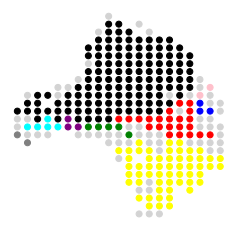

In [6]:
mel, mel_meta = utils.read_ST_data("data/Melanoma/raw.csv")# Read data
mel,_ = utils.data_norm(mraw, "cpm")# Normalize data
mel = mel.loc[good_spots, good_genes] # Apply QC results
mel_meta = mel_meta.loc[good_spots,:]
mel_nodes = neighbors.construct_graph(mel_meta)# Graph representation
mel_cormat = utils.spot_PCA_sims(mel) # Get spot-spot similarity
# Get connected components with the epsilon we knew it was selected by MIST
mel_ccs = neighbors.spatialCCs(mel_nodes, mel_cormat, 0.6, merge=0) 
mel = np.log2(mel + 1) # Log transform
# Get spatial region assignment and tune the colors
df = neighbors.assign_membership(meta=mel_meta, ccs=mel_ccs)
df.loc[df.cluster == "black", "cluster"] = "magenta"
df.loc[df.cluster == "red", "cluster"] = "black"
df.loc[df.cluster == "yellow", "cluster"] = "red"
df.loc[df.cluster == "orange", "cluster"] = "yellow"
df.loc[df["size"] == 1, "cluster"] = "lightgray"
f = plt.figure(figsize=(4,4))
plt.scatter(mel_meta.coordX, mel_meta.coordY, c = df.loc[mel_meta.index, "cluster"].tolist())
plt.gca().invert_yaxis()
plt.axis("off")

In [13]:
## Function to calculate rank sum test p-value and logFC for each gene, each cluster vesus others
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests as adjust_pval

def rank_sum_DEGs(count, meta, genes):
    """This method is used to get the relative DEGs between melanoma region and lymphoid region
        using rank-sum test provided by Python package sklearn.
    """

    meta = meta.loc[count.index,:]# align meta and gene expression
    source = meta.loc[meta.cluster == "black",:].index.tolist() # Get case spots
    target = meta.loc[meta.cluster == "yellow",:].index.tolist() # Get control spots
    lfcs = []
    pvals = []
    for gene in genes:
        svals = count.loc[source, gene].to_numpy()
        tvals = count.loc[target, gene].to_numpy()
        pvals.append(ranksums(svals, tvals)[1]) # Get p-value from rank-sum test
        lfcs.append(np.mean(svals) - np.mean(tvals)) # Get effect size (mean difference, log scaled)
    significance = -np.log10(adjust_pval(pvals)[1] + 1E-10) # -log10(p.adjust)
    deg_dfs = pd.DataFrame({"gene":[g.split()[0] for g in genes], "pval":pvals, "sig": significance, "lfc": lfcs})
    deg_dfs = deg_dfs.sort_values("pval")

    deg_dfs['DEG'] = 'Not significant'
    deg_dfs.loc[(deg_dfs.sig >= 5) & (deg_dfs.lfc >= 1),'DEG'] = 'Up'
    deg_dfs.loc[(deg_dfs.sig >= 5) & (deg_dfs.lfc <= -1), 'DEG'] = 'Down'
    return deg_dfs

## Get DEGs through rank-sum test and save results for volcano plot
### The volcano plot is done using R script

In [17]:
raw_DEG_list = rank_sum_DEGs(mel, df, mel.columns.tolist())
print(raw_DEG_list.loc[np.absolute(raw_DEG_list.lfc >= .59) & (raw_DEG_list.sig >=5)].shape)
raw_DEG_list.to_csv("raw_melanoma_deg_list.csv")

(158, 5)


## Save Lymphoid activated genes for Fig. 2E (GSEA analysis)

In [18]:
lym_genes = raw_DEG_list.loc[(raw_DEG_list.lfc < -.59) & (raw_DEG_list.sig>=2), 'gene'].tolist()
lym_genes = [g.split()[0] for g in lym_genes]
with open("lymphoid_sig_genes.txt", 'w') as f:
    for g in lym_genes:
        f.write("%s\n" %g)
print(len(lym_genes))

111
